# GEX preprocessing for PPI inference

This notebook will work on the filtered single-cell gene expression data from Mahdessian et al. to define appropriate edge costs and node prizes for the Prize-collecting Steiner analyses.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_unweighted
import venn
import networkx as nx
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_1samp, pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import mutual_info_score
import matplotlib.cm as cm

seed = 1234

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def find_markers(data, target, avg_log_fc=0.25, min_pct=0.1):
    target_data = data.loc[target]
    other_data = data.drop([target], axis=0)
    results = {
        "log_expr_target": [],
        "avg_log_expr_other": [],
        "log_fc": [],
        "abs_log_fc": [],
        "pval": [],
    }
    genes = list(data.columns)
    selected_genes = []
    for gene in genes:
        log_other_expr = np.array(other_data.loc[:, gene])
        avg_log_expr_other = log_other_expr.mean()
        log_expr_target = target_data.loc[gene]
        log_fc = log_expr_target - avg_log_expr_other
        # if log_fc > avg_log_fc and np.mean(log_other_expr == 0) <= (1 - min_pct):
        if (
            avg_log_fc < np.abs(log_fc)
            and np.mean(log_other_expr == 0) <= (1 - min_pct)
            and np.mean(log_expr_target == 0) <= (1 - min_pct)
        ):
            results["log_expr_target"].append(log_expr_target)
            results["avg_log_expr_other"].append(avg_log_expr_other)
            results["log_fc"].append(log_fc)
            results["abs_log_fc"].append(np.abs(log_fc))
            results["pval"].append(ttest_1samp(log_other_expr, log_expr_target)[1])
            selected_genes.append(gene)
    results["fdr"] = fdrcorrection(results["pval"])[1]
    results = pd.DataFrame.from_dict(results)
    results.index = selected_genes
    return results

<IPython.core.display.Javascript object>

In [3]:
def search_for_confidence_cutoff(ppi, targets, uncertainty="cost"):
    n_edges = []
    avg_degrees = []
    n_nodes = []
    n_targets = []
    cutoffs = list(np.arange(0, 1, 0.001))
    ppi_edge_list = nx.to_pandas_edgelist(ppi)
    for cutoff in tqdm(cutoffs):
        graph = nx.from_pandas_edgelist(
            ppi_edge_list.loc[ppi_edge_list["cost"] < cutoff, :],
        )
        n_edges.append(len(graph.edges()))
        n_nodes.append(len(graph.nodes()))
        n_targets.append(len((targets).intersection(set(list((graph.nodes()))))))
        degrees = [val for (node, val) in graph.degree()]
        if len(graph.nodes()) > 0:
            avg_degrees.append(sum(degrees) / len(graph.nodes()))
        else:
            avg_degrees.append(0)
    edge_cost_overview = pd.DataFrame.from_dict(
        {
            "cutoff": cutoffs,
            "n_nodes": n_nodes,
            "n_targets": n_targets,
            "n_edges": n_edges,
            "avg_degree": avg_degrees,
        }
    )
    return edge_cost_overview

<IPython.core.display.Javascript object>

In [4]:
def compute_bootstrap_p(x, y, metric, b=1000, random_state=1234):
    np.random.seed(random_state)
    bootstrap_metrics = []
    if metric == "pearson":
        sample_metric = pearsonr(x, y)[0]
    elif metric == "spearman":
        sample_metric = spearmanr(x, y)[0]
    else:
        raise NotImplementedError("Unknown metric provided: {}".format(metric))
    for i in range(b):
        x_boot = np.random.choice(x, size=len(x), replace=True)
        y_boot = np.random.choice(y, size=len(y), replace=True)
        if metric == "pearson":
            bootstrap_metric = pearsonr(x_boot, y_boot)[0]
        elif metric == "spearman":
            bootstrap_metric = spearmanr(x_boot, y_boot)[0]
        else:
            raise NotImplementedError("Unknown metric provided: {}".format(metric))
        bootstrap_metrics.append(bootstrap_metric)
    p_boot = (1 / b) * np.sum(bootstrap_metrics <= sample_metric)
    return p_boot

<IPython.core.display.Javascript object>

In [5]:
def compute_mi_score(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

<IPython.core.display.Javascript object>

In [6]:
def compute_edge_weights(
    ppi,
    data,
    metrics=["pearsonr", "spearmanr", "mi", "pearsonp", "spearmanp"],
    b=1000,
    random_state=1234,
):
    for metric in metrics:
        for (u, v) in tqdm(
            ppi.edges(), desc="Compute edge weights for {}".format(metric)
        ):
            x = np.array(data.loc[:, u])
            y = np.array(data.loc[:, v])
            if metric == "pearsonr":
                association = pearsonr(x, y)[0]
                cost = 1 - np.abs(association)
            elif metric == "spearmanr":
                association = spearmanr(x, y)[0]
                cost = 1 - np.abs(association)
            elif metric == "mi":
                cost = compute_mi_score(x, y, 100)
            elif metric == "pearsonp":
                association = compute_bootstrap_p(
                    x, y, metric="pearson", b=b, random_state=random_state
                )
                cost = association
            elif metric == "spearmanp":
                association = compute_bootstrap_p(
                    x, y, metric="spearman", b=b, random_state=random_state
                )
                cost = association
            else:
                raise NotImplementedError("Unknown metric provided: {}".format(metric))
            ppi.edges[u, v][metric] = cost
    return ppi

<IPython.core.display.Javascript object>

---

## 1. Read in data

We will read in a number of different data sets that we will use for our analyses: a) the single-cell gene expression data from Mahdessian et al. (2021), b) the most recent version of the CCLE expression data set, c) the list of ORF gene targets from the study by Rohban et al. (2017) and finally d) the Human PPI network as defined by the iRefIndexDB v14.

In [7]:
fucci_adata = sc.read("../../../data/gex/scrnaseq/fucci_adata.h5")
fucci_adata.var_names_make_unique()
fucci_data = pd.DataFrame(
    fucci_adata.X, columns=fucci_adata.var_names, index=fucci_adata.obs_names
)
fucci_data.columns = [c.upper() for c in fucci_data.columns]
fucci_data.head()

,TSPAN6,DPM1,SCYL3,C1ORF112,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,...,NOTCH2NLR,SPDYE14,DERPC,BMS1P23,LOC107986257,LOC728392,NOTCH2NLC,SPDYE11,ARMCX5-GPRASP2,LOC114841035
A10_355,4.084212,4.450537,2.539949,3.306074,0.0,3.924660,2.747193,3.980721,3.192863,3.306074,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,3.111745,0.000000,0.0,0.0
A10_356,4.416176,3.408068,0.000000,3.341437,0.0,3.109879,3.637463,2.683064,2.919073,4.264037,...,0.000000,0.0,2.540241,2.038441,1.584074,0.0,0.328890,1.336015,0.0,0.0
A10_357,2.784883,4.266762,0.000000,3.756405,0.0,4.676425,4.027002,4.154050,3.560914,4.211993,...,3.527433,0.0,3.144496,0.000000,0.000000,0.0,3.733050,0.000000,0.0,0.0
A11_355,3.995154,4.196535,1.325398,3.543870,0.0,3.015254,3.015254,4.159373,0.000000,3.481722,...,0.000000,0.0,3.219861,1.930217,0.000000,0.0,2.597980,1.435097,0.0,0.0
A11_356,5.384314,3.358004,2.851447,2.519226,0.0,4.309559,3.807653,3.807653,3.843228,3.843228,...,0.000000,0.0,3.926349,0.000000,0.000000,0.0,0.000000,1.948682,0.0,0.0


<IPython.core.display.Javascript object>

In [8]:
fucci_gene_set = set(fucci_data.columns)

<IPython.core.display.Javascript object>

The single-cell gene expression data from MAhdessian et al. (2021) to which we in the following refer to as FUCCI data set consists of 1'126 cells a 21'445.

In [9]:
ccle_data = pd.read_csv("../../../data/gex/ccle/CCLE_expression.csv", index_col=0)
ccle_sample_info = pd.read_csv(
    "../../../data/gex/ccle/CCLE_expression_sample_info.csv", index_col=0
)
matched_ids = set(ccle_sample_info.index).intersection(ccle_data.index)
ccle_data = ccle_data.loc[list(matched_ids)]
ccle_data.index = ccle_sample_info.loc[ccle_data.index, "stripped_cell_line_name"]
ccle_data.columns = [c.split(" ")[0].upper() for c in ccle_data.columns]
ccle_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1ORF112,FGR,CFH,FUCA2,GCLC,NFYA,...,ARHGAP11B,AC004593.2,AC090517.4,AL160269.1,ABCF2-H2BE1,POLR2J3,H2BE1,AL445238.1,GET1-SH3BGR,AC113348.1
stripped_cell_line_name,,,,,,,,,,,,,,,,,,,,,
HOP92,4.296457,0.000000,5.646739,2.053111,2.841973,0.097611,1.049631,6.586314,3.849999,4.167519,...,0.871844,0.367371,0.137504,0.475085,3.990955,5.524816,0.0,0.176323,1.356144,0.000000
CME1,5.166314,0.344828,6.743353,2.361768,3.904966,0.000000,1.000000,0.150560,4.148121,4.385431,...,1.063503,0.000000,0.333424,0.042644,1.604071,5.768184,0.0,0.000000,0.565597,0.070389
HPBALL,0.084064,0.000000,5.373648,2.531069,4.713696,7.763412,0.226509,3.460743,4.576522,5.583158,...,2.277985,0.176323,0.214125,0.000000,2.528571,5.669877,0.0,0.000000,0.985500,0.028569
OVKATE,4.853497,0.028569,6.474598,3.001802,4.100137,0.895303,4.165912,4.721373,3.450221,3.757023,...,2.922198,0.084064,0.042644,0.963474,2.704872,5.831877,0.0,0.000000,1.104337,0.000000
SNU1033,5.353323,0.124328,6.436295,2.462052,3.964399,0.014355,2.695994,6.900625,4.862451,3.408712,...,0.910733,0.214125,0.000000,0.000000,2.648465,4.734439,0.0,0.000000,0.214125,0.000000


<IPython.core.display.Javascript object>

In [10]:
ccle_gene_set = set(ccle_data.columns)

<IPython.core.display.Javascript object>

The second data set from the CCLE study consist of 1'378 cancer cell lines for which we obtain the expression of roughly 19'177 genes.

In [11]:
orf_targets = set(
    pd.read_csv(
        "../../../data/other/gene_target_list.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [12]:
cell_cycle_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_cell_cycle.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [13]:
chrom_org_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_chrom_org.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [14]:
dna_repair_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_dna_repair.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [15]:
reg_actin_cytoskeleton_genes = set(
    pd.read_csv(
        "../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0, header=None
    ).index
)

<IPython.core.display.Javascript object>

In [16]:
specificity_screen_results = pd.read_csv(
    "../../..//data/other/specificity_screen_results.csv", index_col=0
)
specificity_screen_results.head()

,multi_image_spec_score,nuclei_image_spec_score,spec_score,rohban_selected,pathways_of_interest,selected
MAPK13,0.586119,0.547602,0.586119,False,False,False
AKT2,0.604911,0.547991,0.604911,False,True,False
MAP3K7,0.468750,0.530357,0.530357,True,False,False
IKBKB,0.685855,0.607730,0.685855,False,False,True
IRAK1,0.620404,0.538603,0.620404,False,False,False


<IPython.core.display.Javascript object>

In [17]:
specific_targets = set(
    specificity_screen_results.loc[specificity_screen_results["selected"] == True].index
)

<IPython.core.display.Javascript object>

In [18]:
ppi_file = "../../../data/ppi/iRefIndex_v14_MIScore_interactome_C9.costs.txt"
iref_ppi = nx.convert_matrix.from_pandas_edgelist(
    pd.read_csv(ppi_file, sep="\t"),
    source="protein1",
    target="protein2",
    edge_attr="cost",
)
iref_ppi.remove_edges_from(nx.selfloop_edges(iref_ppi))

<IPython.core.display.Javascript object>

In [19]:
ppi_gene_set = set(list(iref_ppi.nodes()))

<IPython.core.display.Javascript object>

The Venn diagram below shows the overlap of the two gene sets with the 190 ORF targets from the study by Rohban et al. (2017) as well as with the ones from iRefIndexDB v14. That we will use later on as a basis to derive the interactome specific to the U2OS cells.

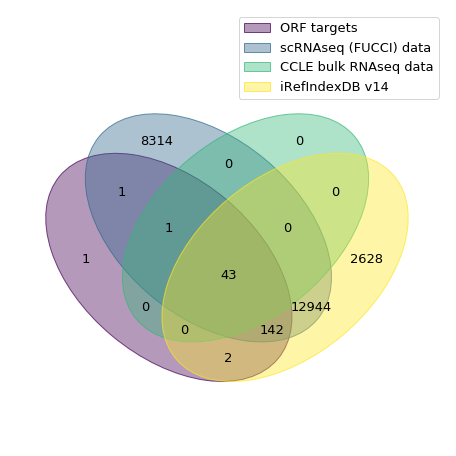

<IPython.core.display.Javascript object>

In [21]:
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "scRNAseq (FUCCI) data",
                "CCLE bulk RNAseq data",
                "iRefIndexDB v14",
            ],
            [
                orf_targets,
                fucci_gene_set,
                ccle_gene_set,
                ppi_gene_set,
            ],
        )
    )
)

In [35]:
selected_orf_targets = orf_targets.intersection(fucci_gene_set).intersection(
    ppi_gene_set
)
# pd.DataFrame(list(selected_orf_targets)).to_csv(
#     "../../../data/other/selected_orf_targets.txt", header=False, index=False
# )

<IPython.core.display.Javascript object>

Going forward, we will focus on the intersection of the genes that are covered in the scRNAseq (FUCCI) data set, the CCLE bulk RNAseq data set and the iRefIndexDB v14. While we will have not yet decided to use the bulk-sequencing data restricting us to those genes also covered by this gene expression data set only removes 61 genes including four known transcription factors (NFE4, ZNF286B, ZNF658B, ZNF702P) transcription factor nor any of the ORF targets, which are shown below.

In [22]:
human_tfs = set(
    list(
        pd.read_csv(
            "../../../data/other/human_tf_list.txt", index_col=0, header=None
        ).index
    )
)

<IPython.core.display.Javascript object>

In [37]:
(
    fucci_gene_set.intersection(ppi_gene_set)
    - set(fucci_data.columns).intersection(ppi_gene_set).intersection(ccle_gene_set)
).intersection(human_tfs)

{'NFE4', 'ZNF286B', 'ZNF658B', 'ZNF702P'}

<IPython.core.display.Javascript object>

In [38]:
selected_gene_set = fucci_gene_set.intersection(ppi_gene_set).intersection(
    ccle_gene_set
)
len(selected_gene_set)

13068

<IPython.core.display.Javascript object>

---

## 2. Identification of U2OS gene set

In total we have 13'068 genes that we selected for further analyses. However, we have to yet identify those that are particularly important in the functional and thus regulatory programs of our cell type: human osteosarcoma (U2OS) cells.

### 2a. Filtering out lowly expressed genes

First, we are interested in finding those genes that are highly expressed in the given cell type to this end, we will first plot the average gene expression for each individual gene of our scRNA-seq data set for the subset of genes that we selected as discussed previously. For better visualization we will order them according to their mean expression.

In [39]:
selected_fucci_data = fucci_data.loc[:, selected_gene_set]
# mean_expression = selected_fucci_data.mean().sort_values(ascending=False)
median_expression = selected_fucci_data.median().sort_values(ascending=False)

<IPython.core.display.Javascript object>

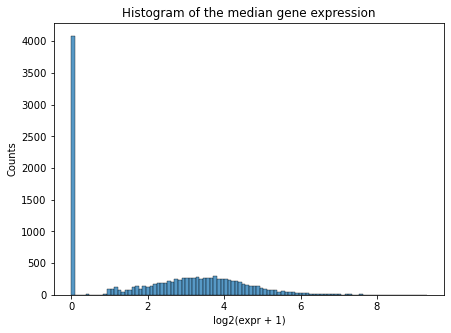

<IPython.core.display.Javascript object>

In [40]:
plt.figure(figsize=[7, 5])
sns.histplot(x=np.array(median_expression), bins=100)
plt.title("Histogram of the median gene expression")
plt.xlabel("log2(expr + 1)")
plt.ylabel("Counts")
plt.show()

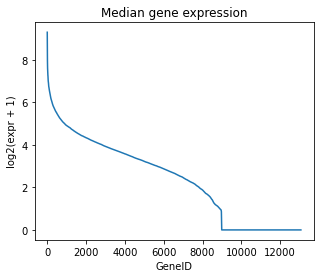

<IPython.core.display.Javascript object>

In [41]:
plt.figure(figsize=[5, 4])
plt.plot(list(range(len(median_expression))), np.array(median_expression))
plt.title("Median gene expression")
plt.ylabel("log2(expr + 1)")
plt.xlabel("GeneID")
plt.show()

The empirical distribution of the median gene expression seems to follow roughly a bi-modal distribution. Going forward we are less interested in genes that are very lowly expressed. The intuition is that a) for genes that are low expressed there is greater level of measurement noise (Sha et al., 2015) and b) these are expected to play a less important role in the functional regulation of the cell.

Thus, we will filter out such lowly expressed genes which we define as those with being predicted to be part of the background distribution that is of the component with smaller mean of a two-component Gaussian mixture model that we fit to the average gene expression values.

In [42]:
gmm = GaussianMixture(n_components=2, random_state=seed)
fitted_gmm = gmm.fit(np.array(median_expression).reshape(-1, 1))
preds_median = fitted_gmm.predict(np.array(median_expression).reshape(-1, 1))
pred_median_labels = []
for pred in preds_median:
    if pred == 0:
        pred_median_labels.append("low expressed")
    else:
        pred_median_labels.append("other")

<IPython.core.display.Javascript object>

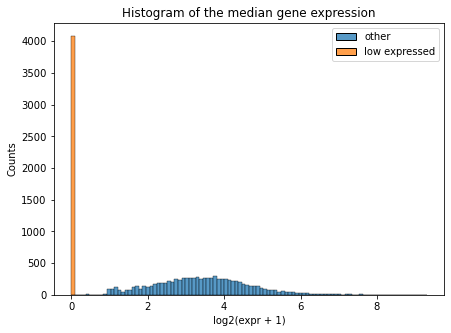

<IPython.core.display.Javascript object>

In [43]:
plt.figure(figsize=[7, 5])
sns.histplot(x=np.array(median_expression), bins=100, hue=pred_median_labels)
plt.title("Histogram of the median gene expression")
plt.xlabel("log2(expr + 1)")
plt.ylabel("Counts")
plt.show()

We estimate a cutoff for the mean gene expression that has been log+1-transformed after scaling to each gene expression profile to unit length for each cell to account for varying sequencing depth of 0.3417. 

In [44]:
med_gex_threshold = (np.array(median_expression)[preds_median == 0]).max()
med_gex_threshold

0.0

<IPython.core.display.Javascript object>

In [45]:
background_genes = set(
    median_expression.loc[median_expression <= med_gex_threshold].index
)
foreground_genes = set(
    median_expression.loc[median_expression > med_gex_threshold].index
)
len(background_genes), len(foreground_genes)

(4084, 8984)

<IPython.core.display.Javascript object>

Thereby, we find 4084 genes that we classify as lowly expressed among which are 543 human transcription factors.

In [46]:
len(background_genes.intersection(human_tfs))

543

<IPython.core.display.Javascript object>

We are thus left with 10'478 genes after that filtering step including 1'162 transcription factors and 177/190 ORF targets.

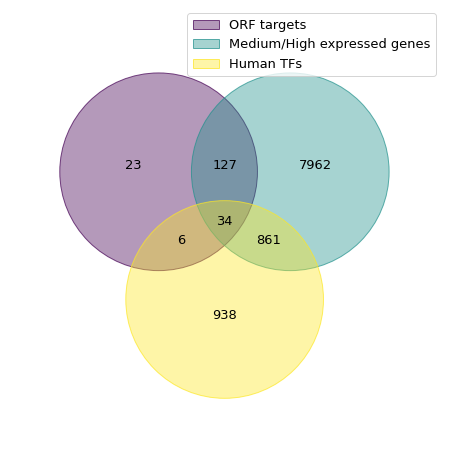

<IPython.core.display.Javascript object>

In [47]:
ax = venn.venn(
    dict(
        zip(
            ["ORF targets", "Medium/High expressed genes", "Human TFs"],
            [orf_targets, foreground_genes, human_tfs],
        )
    )
)

Among those background genes are also 23 ORF targets. We hypothesized that the background genes might correspond to pathways that are typical silent in the wild-type setting but might be imported in an overexpression setting such as toxic interventions leading to apoptosis.

In [48]:
death_genes = list(
    pd.read_csv("../../../data/other/reactome_cell_death.tsv", index_col=0, sep="\t")[
        "MoleculeName"
    ]
)
death_genes = set([gene.split(" ")[-1] for gene in death_genes])

<IPython.core.display.Javascript object>

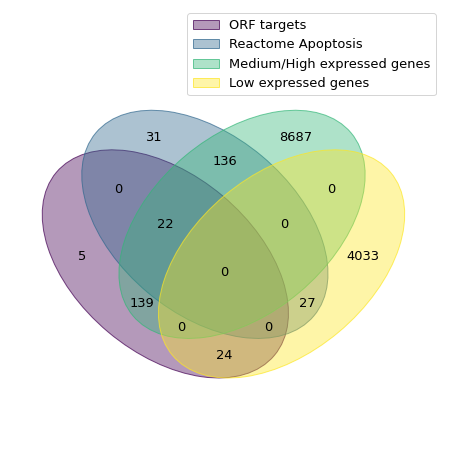

<IPython.core.display.Javascript object>

In [49]:
ax = venn.venn(
    dict(
        zip(
            [
                "ORF targets",
                "Reactome Apoptosis",
                "Medium/High expressed genes",
                "Low expressed genes",
            ],
            [orf_targets, death_genes, foreground_genes, background_genes],
        )
    )
)

When looking at the Reactome geneset for apoptosis we however see that those genes are actually significantly under-represented in the background gene set contradicting our hypothesis.

However, when having a closer look at the ORF targets (see below) that were identified to be background genes based on their low expression, we find that e.g. CEBPA (median. log-expr: 0.0) is among them which showed a drastic change in the cellular morphology upon over-expression. We would not want exclude such genes from our analyses.

We could pursue an approach where we only remove low-expressed genes that are not ORF targets, however it is likely that expression of these are co-regulated with certain other genes that upon over-expression lead to the drastic morphological changes. Thus, it is desirable to include also low-expressed genes in the analyses to not also capture important signaling pathways that are turned off in wildtype U2OS cells but lead to significant structural changes in the cell upon activation via overexpression.

In [50]:
orf_targets.intersection(background_genes)

{'AXIN2',
 'BAMBI',
 'BMP2',
 'BMPR1B',
 'CEBPA',
 'CXXC4',
 'DEPTOR',
 'DKK1',
 'DLL1',
 'ERG',
 'FGFR3',
 'FOXO1',
 'GLI1',
 'JAK2',
 'MAP3K5',
 'MAP3K8',
 'MAPK13',
 'MKNK1',
 'PHLPP1',
 'PPARGC1A',
 'SMAD7',
 'TNFAIP3',
 'VEGFC',
 'WNT5A'}

<IPython.core.display.Javascript object>

---

### 2b. Identification of U2OS marker genes

The set of genes that we identified as not being moderately expressed in U2OS cells forms one possible subset of genes of interest for the derivation of the cell-type specific interactome.

One alternative approach is to define a marker gene set for the given cell type by finding those genes that are significantly overexpressed in U2OS cell compared to other cell types. To identify such a set we will focus on the CCLE data spanning over 1300 different cancer cell lines. Note that this will likely lead to a selection of genes that are highly specific to that cell type due to the comparison to other cancer cell lines only.

To identify a the markers, we will run a screen testing for every gene if the mean expression of all other cancer cell lines is significantly smaller than the expression of that respective gene for U2OS cells using the bulk RNAseq data. In particular, we will test the following for each gene:

$$
H_A: \quad \bar{x}_i < x_{i,U2OS}, \quad \textrm{with} \ \bar{x}_i=\frac{1}{N-1}\sum\limits_{j\neq U2OS}x_{i,j}
$$
where $x_{i,j}$ is the transformed expression of gene $i$ in cell type $j$.

In [51]:
marker_results = find_markers(
    ccle_data,
    target="U2OS",
    avg_log_fc=0.0,
    min_pct=0,
)

<IPython.core.display.Javascript object>

The table below shows the top 10 genes that show the largest absolute log-fold change when comparing U2OS cells vs. the other cancer cell lines of the CCLE data set.

In [52]:
marker_results.loc[(marker_results["fdr"] < 0.05)].sort_values(
    "abs_log_fc", ascending=False
).head(10)

,log_expr_target,avg_log_expr_other,log_fc,abs_log_fc,pval,fdr
DHRS2,10.913937,2.265074,8.648862,8.648862,0.0,0.0
TUBA3C,8.172977,0.363201,7.809776,7.809776,0.0,0.0
XAGE1B,9.351337,1.736868,7.614469,7.614469,0.0,0.0
PAGE2,7.891055,0.447193,7.443861,7.443861,0.0,0.0
PAGE2B,7.760687,0.404266,7.356420,7.356420,0.0,0.0
HAPLN1,7.514122,0.537060,6.977062,6.977062,0.0,0.0
KRT81,9.080338,2.109525,6.970813,6.970813,0.0,0.0
PCLO,8.285310,1.510797,6.774512,6.774512,0.0,0.0
KRT17,9.705892,2.965366,6.740525,6.740525,0.0,0.0
XAGE1A,7.796364,1.283182,6.513182,6.513182,0.0,0.0


<IPython.core.display.Javascript object>

The figure below shows the exponential decay of the absolute logFC values for the roughly 18k genes in the CCLE data set.

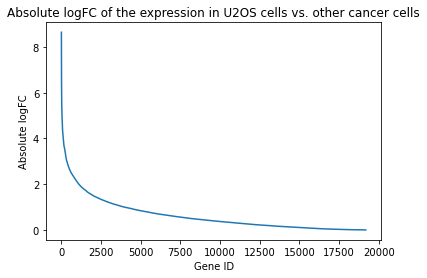

<IPython.core.display.Javascript object>

In [53]:
plt.figure()
plt.plot(
    list(range(len(marker_results))),
    np.array(
        marker_results.sort_values("abs_log_fc", ascending=False).loc[:, "abs_log_fc"]
    ),
)
plt.ylabel("Absolute logFC")
plt.xlabel("Gene ID")
plt.title("Absolute logFC of the expression in U2OS cells vs. other cancer cells")
plt.show()

When we look at the log-fold change of the ORF targets, we see that many of these show a log-fold change below 1. Importantly, many of these however show an important structural response when overexpressed by ORF constructs like CASP8 which is highly toxic upon overexpression.

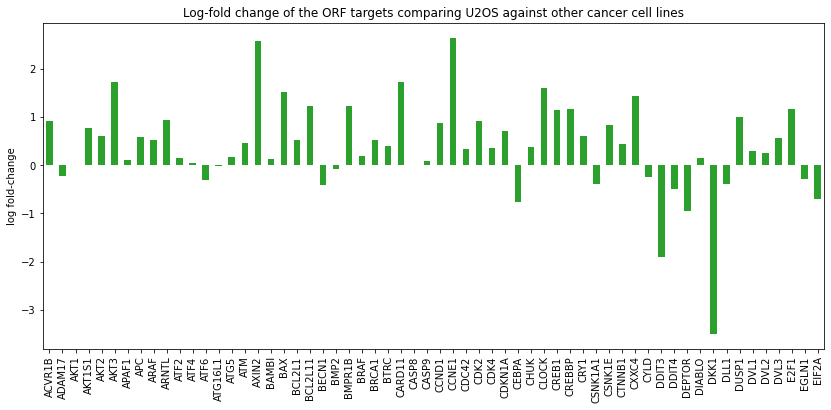

<IPython.core.display.Javascript object>

In [54]:
orf_log_fc = marker_results.loc[
    set(list(marker_results.index)).intersection(orf_targets), "log_fc"
]
orf_log_fc.sort_index().iloc[:60].plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

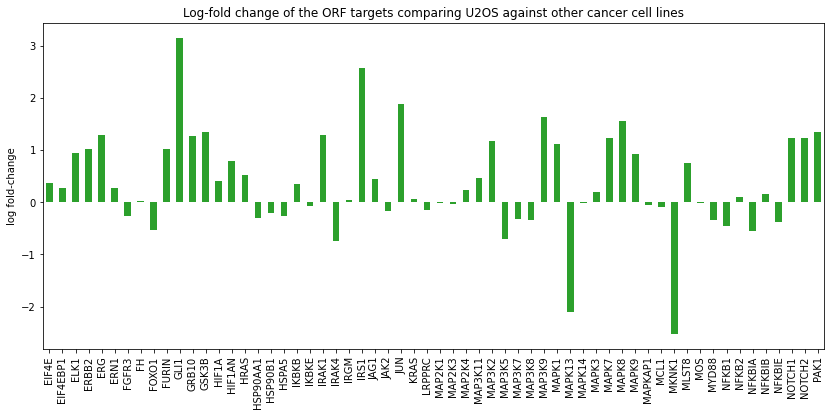

<IPython.core.display.Javascript object>

In [55]:
orf_log_fc.sort_index().iloc[60:120].plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

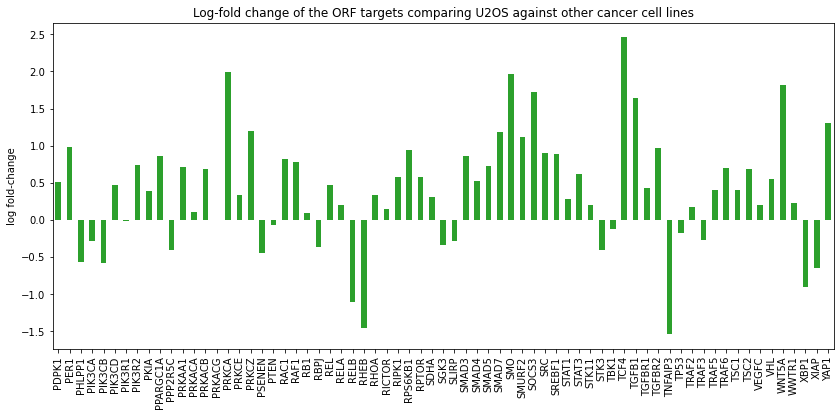

<IPython.core.display.Javascript object>

In [56]:
orf_log_fc.sort_index().iloc[120:].plot.bar(figsize=[14, 6], color="tab:green")
plt.ylabel("log fold-change")
plt.title(
    "Log-fold change of the ORF targets comparing U2OS against other cancer cell lines"
)
plt.show()

This is important to keep in mind for the later inference.

---

## 3. Preprocessing the PPI

In the following we will prune the PPI to remove low-confidence edges and respective disconnected components. To this end, we first aim to find a cut-off for the given edge costs that correspond to a measure of uncertainty for the existance of an interaction in the PPI between any pair of nodes.

The plots below illustrate the number of nodes, number of edges the average degree and the number of covered ORF targets for different cutoff values for the certainty of the respective edges of the subgraph of the human PPI induced by selecting only those gene covered by the scRNA-seq data set.

In [57]:
filtered_ppi = iref_ppi.subgraph(fucci_gene_set)
print(nx.info(filtered_ppi))

Name: 
Type: Graph
Number of nodes: 13129
Number of edges: 154269
Average degree:  23.5005


<IPython.core.display.Javascript object>

In [58]:
confidence_cutoff_search_results = search_for_confidence_cutoff(
    filtered_ppi, targets=orf_targets
)

100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]


<IPython.core.display.Javascript object>

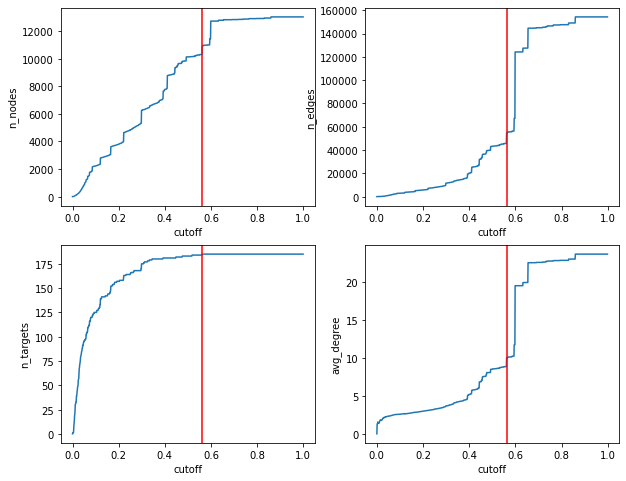

<IPython.core.display.Javascript object>

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[10, 8])
ax = ax.flatten()
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_nodes", ax=ax[0])
ax[0].axvline(x=0.562, color="r")
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_edges", ax=ax[1])
ax[1].axvline(x=0.562, color="r")
sns.lineplot(data=confidence_cutoff_search_results, x="cutoff", y="n_targets", ax=ax[2])
ax[2].axvline(x=0.562, color="r")
sns.lineplot(
    data=confidence_cutoff_search_results, x="cutoff", y="avg_degree", ax=ax[3]
)
ax[3].axvline(x=0.562, color="r")
plt.show()

We see that the average degree and the number of edges jumps at a level around 0.6. Importantly, at this point all 185 ORF targets are already included in the graph. Thus, we will prune the network to remove all edges with a cost higher than the highest edge prize connecting any of the targets, i.e. the minimum cutoff value for which the number of targets that are covered in the respective subgraph are 185.

In [60]:
confidence_cutoff_search_results.loc[
    confidence_cutoff_search_results["n_targets"] == 185
].sort_values("cutoff").head(1)

,cutoff,n_nodes,n_targets,n_edges,avg_degree
562,0.562,10900,185,54582,10.015046


<IPython.core.display.Javascript object>

That is the case for a cutoff of 0.562. At this point the induced subgraph consists of 10'900 nodes and 54'592 edges and an average node degree of 10.02.

In [61]:
filtered_ppi_edge_list = nx.to_pandas_edgelist(filtered_ppi)
pruned_ppi = nx.nx.from_pandas_edgelist(
    filtered_ppi_edge_list.loc[filtered_ppi_edge_list["cost"] < 0.562, :]
)

<IPython.core.display.Javascript object>

In [62]:
covered_orf_target_df = pd.read_csv(
    "/home/paysan_d/Desktop/covered_orf_targets.csv", index_col=0
)
covered_orf_target_df.loc[
    set(covered_orf_target_df.index).intersection(cell_cycle_genes),
    "reactome_cell_cyle",
] = 1
covered_orf_target_df.loc[
    set(covered_orf_target_df.index).intersection(reg_actin_cytoskeleton_genes),
    "kegg_cytoskeleton",
] = 1
covered_orf_target_df.loc[
    set(covered_orf_target_df.index).intersection(chrom_org_genes), "reactome_chrom_org"
] = 1
covered_orf_target_df.loc[
    set(covered_orf_target_df.index).intersection(dna_repair_genes),
    "reactome_dna_repair",
]
covered_orf_target_df.loc[
    set(covered_orf_target_df.index).intersection(human_tfs), "transcription_factor"
] = 1
covered_orf_target_df.to_csv("../../../data/other/covered_orf_target_analyses.csv")

<IPython.core.display.Javascript object>

The pruned PPI consists of 28 connected components: one large component connecting 10'841 nodes, 5 tripplets and and 22 doublets. Importantly, all 185 ORF targets are covered in the largest connected component.

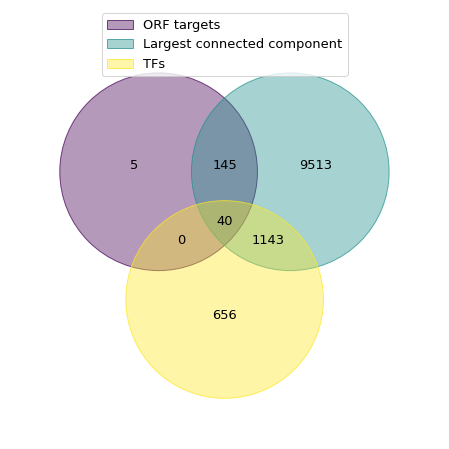

<IPython.core.display.Javascript object>

In [63]:
ccomps = [pruned_ppi.subgraph(c).copy() for c in nx.connected_components(pruned_ppi)]
largest_ccomp = ccomps[0]
ax = venn.venn(
    dict(
        zip(
            ["ORF targets", "Largest connected component", "TFs"],
            [orf_targets, set(largest_ccomp.nodes()), human_tfs],
        )
    ),
    legend_loc="upper center",
)

In the following we will only work with that component.

In [64]:
pruned_ppi = largest_ccomp

<IPython.core.display.Javascript object>

As intermediate step let us save the induced subgraph that we refer to as the confidence pruned PPI.

In [65]:
pd.DataFrame(list(set(pruned_ppi).intersection(fucci_gene_set))).to_csv(
    "../../../data/ppi/selected_ppi_nodes.csv", header=False, index=False
)

<IPython.core.display.Javascript object>

Next, we will further analyze the network and aim to reduce its connectivity by excluding large hub-nodes that are of less interest for our further analyses and might disguise important indirect links between certain targets.
Thus, let us look at the distribution of the degrees of the nodes in the network.

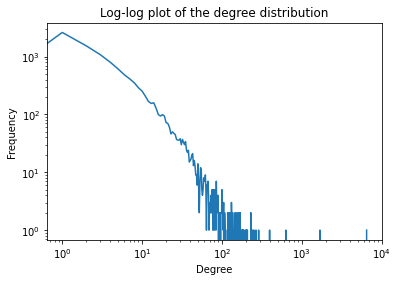

<IPython.core.display.Javascript object>

In [66]:
degree_freq = nx.degree_histogram(pruned_ppi)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Log-log plot of the degree distribution")
plt.show()

We see that there are a few nodes with extreme high degrees. In order to avoid a bias for those nodes in the downstream task of inferring the U2OS specific interactome, we will remove some of such hub nodes from the interactome. This is further motivated by the fact that we would like to emphasize the differences between individual pathways in which our observed ORF targets are included.

In [67]:
degrees_dict = dict(pruned_ppi.degree())
degrees_dict = {
    k: v
    for k, v in sorted(degrees_dict.items(), key=lambda item: item[1], reverse=True)
}
nodes = np.array(list(degrees_dict.keys()))
degrees = np.array(list(degrees_dict.values()))

<IPython.core.display.Javascript object>

To determine an appropriate cutoff of for degree of the nodes to identify those hubnodes that we do not want to take into further consideration, we look at the number of ORF targets that are included in the selected gene set, when using different percentile-cutoffs for the node degree.

In [68]:
def run_hub_node_cutoff_analyses(
    ppi, cutoffs, targets, keep_targets=True, specific_targets=None
):
    degree_dict = dict(ppi.degree())
    nodes = np.array(list(degree_dict.keys()))
    degrees = np.array(list(degree_dict.values()))

    results = {
        "cutoff": [],
        "n_connected_components": [],
        "n_nodes_largest_comp": [],
        "n_targets_largest_comp": [],
        "n_edges_largest_comp": [],
        "avg_degree_largest_comp": [],
    }
    if specific_targets is not None:
        results["specific_targets"] = []
    for cutoff in tqdm(cutoffs, desc="Screen cutoffs"):
        results["cutoff"].append(cutoff)
        selected_nodes = set(list(nodes[degrees <= np.quantile(degrees, cutoff)]))
        if keep_targets:
            selected_nodes = selected_nodes.union(
                targets.intersection(set(list(nodes)))
            )
        s_ppi = ppi.subgraph(selected_nodes)
        ccomps = [s_ppi.subgraph(c).copy() for c in nx.connected_components(s_ppi)]
        largest_comp = max(ccomps, key=len)
        results["n_connected_components"].append(len(ccomps))
        results["n_nodes_largest_comp"].append(len(largest_comp.nodes()))
        results["n_edges_largest_comp"].append(len(largest_comp.edges()))
        results["avg_degree_largest_comp"].append(
            np.mean(list(dict(largest_comp.degree()).values()))
        )
        results["n_targets_largest_comp"].append(
            len(targets.intersection(largest_comp.nodes()))
        )
        if specific_targets is not None:
            results["specific_targets"].append(
                len(specific.targets.intersection(largest_comp.nodes()))
            )
    return pd.DataFrame(results)

<IPython.core.display.Javascript object>

In [69]:
cutoffs = np.arange(0, 1, 0.001)
hub_node_cutoff_screen = run_hub_node_cutoff_analyses(
    pruned_ppi, cutoffs=cutoffs, targets=orf_targets, keep_targets=False
)

Screen cutoffs: 100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


<IPython.core.display.Javascript object>

In [70]:
hub_node_cutoff_screen

,cutoff,n_connected_components,n_nodes_largest_comp,n_targets_largest_comp,n_edges_largest_comp,avg_degree_largest_comp
0,0.000,2615,1,0,0,0.000000
1,0.001,2615,1,0,0,0.000000
2,0.002,2615,1,0,0,0.000000
3,0.003,2615,1,0,0,0.000000
4,0.004,2615,1,0,0,0.000000
...,...,...,...,...,...,...
995,0.995,2059,8689,167,36777,8.465186
996,0.996,2000,8761,173,38141,8.706997
997,0.997,1912,8862,176,39675,8.953961
998,0.998,1803,8986,181,41422,9.219230


<IPython.core.display.Javascript object>

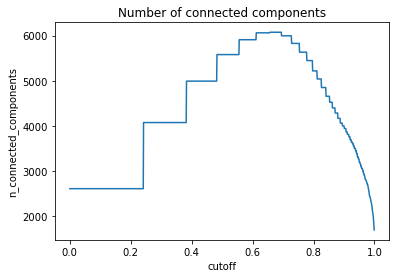

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_connected_components", ax=ax
)
plt.title("Number of connected components")
plt.show()

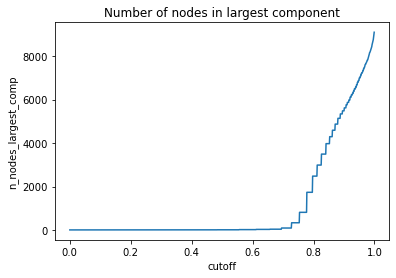

<IPython.core.display.Javascript object>

In [72]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_nodes_largest_comp", ax=ax
)
plt.title("Number of nodes in largest component")
plt.show()

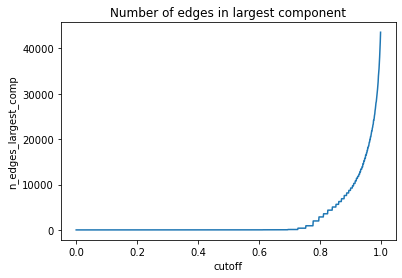

<IPython.core.display.Javascript object>

In [73]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_edges_largest_comp", ax=ax
)
plt.title("Number of edges in largest component")
plt.show()

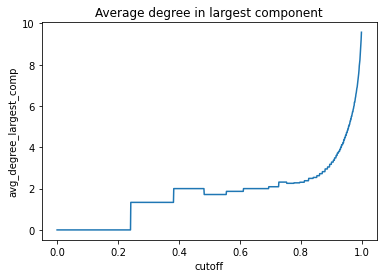

<IPython.core.display.Javascript object>

In [74]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="avg_degree_largest_comp", ax=ax
)
plt.title("Average degree in largest component")
plt.show()

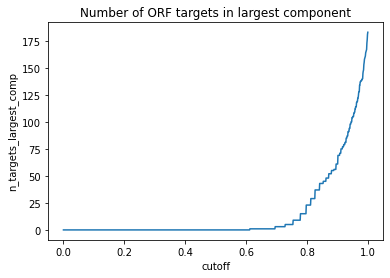

<IPython.core.display.Javascript object>

In [75]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.lineplot(
    data=hub_node_cutoff_screen, x="cutoff", y="n_targets_largest_comp", ax=ax
)
plt.title("Number of ORF targets in largest component")
plt.show()

In [61]:
degree_cutoff = np.quantile(list(dict(pruned_ppi.degree()).values()), 0.999)
hubnodes = nodes[degrees >= degree_cutoff]
non_hubnodes = nodes[degrees < degree_cutoff]
np.sum(orf_target_degrees <= degree_cutoff)

NameError: name 'orf_target_degrees' is not defined

<IPython.core.display.Javascript object>

We see that there are 72, 162, 184 of the ORF targets selected when we chose 0.9, 0.99 or 0.999 as a cutoff. The nodes in the upper 0.1-percentile of the degree distribution are the following 11 that all have a degree larger than 232.

In [ ]:
for n in hubnodes:
    print("Node:", n, "(", degrees_dict[n], ")")

Among those genes there is one ORF target namely the tumor protein P53 (TP53).

To further guide the selection of an appropriate cutoff we will additionally look at the results of the specificity screen, where we trained a classifier for each ORF target on separating between the treatment and the negative control condition on a balanced data set of pairs of single nuclei and FoV images. The balance was obtained by randomly subsampling samples from the control condition.

The following plot shows the degree of the single ORF targets vs the minimum of the validation and testing accuracy of the results of the specificity screen. The reasoning for not only looking at the testing accuracy is due to reduce the effect of outliers where the distribution of the test set by chance was significantly closer to the training set distribution than those of the validation, i.e. to account for the uncertainty of the testing performance of the model.

In [ ]:
spec_screen_results = pd.read_csv(
    "../../../data/experiments/image_embeddings/nuclei_screen/screen_results.csv",
    index_col=0,
)
spec_screen_results.index = spec_screen_results.loc[:, "target"]

spec_comp_dict = {"target": [], "min_val_test_acc": [], "degree": []}
for target in orf_targets.intersection(pruned_ppi.nodes()):
    spec_comp_dict["target"].append(target)
    spec_comp_dict["min_val_test_acc"].append(
        spec_screen_results.loc[target, "min_val_test_acc"]
    )
    spec_comp_dict["degree"].append(degrees_dict[target])
spec_comp_df = pd.DataFrame.from_dict(spec_comp_dict)
spec_comp_df.index = spec_comp_df.target
spec_comp_df = spec_comp_df.drop(columns=["target"])

In [ ]:
ax = sns.scatterplot(data=spec_degree_df, x="degree", y="min_val_test_acc", alpha=0.6)
plt.title("Specificity score vs degree")
plt.show()

In [ ]:
spec_comp_df.sort_values("degree", ascending=False).head(10)

In [ ]:
spec_comp_df["abs_logfc_ccle"] = np.array(
    marker_results.loc[spec_comp_df.index, "abs_log_fc"]
)

In [ ]:
ax = sns.scatterplot(
    data=spec_comp_df,
    x="abs_logfc_ccle",
    y="min_val_test_acc",
    color="tab:green",
    alpha=0.6,
)
plt.title("Specificity score vs abs logFC CCLE data")
plt.show()

In [ ]:
spec_comp_df.sort_values("abs_logfc_ccle", ascending=False).head(10)

In [ ]:
spec_comp_df["PoI"] = np.array(spec_comp_df.index.isin(poi_genes))

In [ ]:
sns.histplot(data=spec_comp_df, x="min_val_test_acc", hue="PoI")
plt.show()

Importantly, the subgraph induced by removing the identified hubnodes from the network remains fully connected.

In [176]:
selected_ppi = nx.Graph(pruned_ppi.subgraph(non_hubnodes))
selected_ppi.name = "Confidence and hubnode pruned PPI"
print(nx.info(selected_ppi))

Name: Confidence and hubnode pruned PPI
Type: Graph
Number of nodes: 10830
Number of edges: 43588
Average degree:   8.0495


<IPython.core.display.Javascript object>

In [177]:
ccomps = [
    selected_ppi.subgraph(c).copy() for c in nx.connected_components(selected_ppi)
]
for comp in ccomps:
    if len(orf_targets.intersection(comp.nodes())) > 0:
        print(nx.info(comp))
        print(len(orf_targets.intersection(comp.nodes())))
        print(orf_targets.intersection(comp.nodes()))

Name: Confidence and hubnode pruned PPI
Type: Graph
Number of nodes: 9103
Number of edges: 43563
Average degree:   9.5711
183
{'SMURF2', 'VEGFC', 'RELB', 'IKBKE', 'CASP8', 'PPARGC1A', 'DVL2', 'PTEN', 'CASP9', 'XIAP', 'CCND1', 'MAPK13', 'MAPK7', 'CARD11', 'MAP3K7', 'MAP3K8', 'MAPK3', 'TRAF5', 'PIK3R2', 'NOTCH1', 'ERN1', 'DKK1', 'SOCS3', 'FGFR3', 'SMAD3', 'RELA', 'PRKAA1', 'HIF1AN', 'PIK3CD', 'MYD88', 'TNFAIP3', 'PKIA', 'CRY1', 'RAC1', 'TSC1', 'EGLN1', 'RHEB', 'BMP2', 'SGK3', 'ERBB2', 'CSNK1A1', 'ELK1', 'MAPK14', 'BCL2L11', 'MAP3K11', 'NFKB2', 'RPS6KB1', 'PRKACB', 'ATG5', 'ERG', 'CDK2', 'BRAF', 'JAK2', 'RB1', 'TBK1', 'AKT3', 'WNT5A', 'MAPK8', 'DEPTOR', 'PRKCE', 'RIPK1', 'TRAF6', 'SRC', 'DDIT3', 'PPP2R5C', 'EIF4E', 'SLIRP', 'APC', 'NFKBIE', 'MAPK1', 'ARNTL', 'NFKBIA', 'KRAS', 'PAK1', 'MAP2K3', 'GSK3B', 'VHL', 'TGFB1', 'CDK4', 'MAP2K4', 'PRKCA', 'EIF4EBP1', 'HIF1A', 'CDC42', 'CEBPA', 'REL', 'BTRC', 'BAX', 'NFKB1', 'HSP90B1', 'RPTOR', 'CREBBP', 'MAP3K2', 'ATG16L1', 'DUSP1', 'BRCA1', 'TSC2',

<IPython.core.display.Javascript object>

In [178]:
selected_ppi = ccomps[0]

<IPython.core.display.Javascript object>

The induced subgraph spans 10'830 nodes including 184/185 ORF targets and is fully connected with an average degree of 8.05 stemming from 43'588 edges.

---

## 4. Relationship strength of the between the selected genes

In this section we will look at ways to define the edge costs for the Prize-collecting Steiner tree inference-based derivation of the U2OS-specific interactome. To this end, we will look at three different measures that are often used to describe the association of genes to guide the derivation of regulatory networks and interactomes, namely the Pearson correlation, the Spearman correlation and the normalized mutual information. Since, we want to assign higher costs to for relationships between any pair of genes that we have little evidence for as measured by the three previously mentioned metrics, we compute these as

$$
w_{i,j} = 1-|a_{i,j}|,
$$

where $w_{i,j}$ is the edge weight and $a_{i,j}$ is the respective association of the genes $i$ and $j$ as measured by the metrics.

Those metrics are sensitive to outliers. This is another explanation why we focused on highly expressed genes in the derivation of the base PPI.

We will now compute the respective edge weights for any edge in the base PPI and visualize their distribution.

In [180]:
selected_ppi = compute_edge_weights(
    selected_ppi, fucci_data, b=100, metrics=["pearsonr", "spearmanr", "mi"]
)

Compute edge weights for mi: 100%|██████████| 43563/43563 [00:29<00:00, 1501.34it/s]


<IPython.core.display.Javascript object>

### 4.1. Pearson correlation-based edge weights

In [181]:
pearsonr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "pearsonr").values())
)

<IPython.core.display.Javascript object>

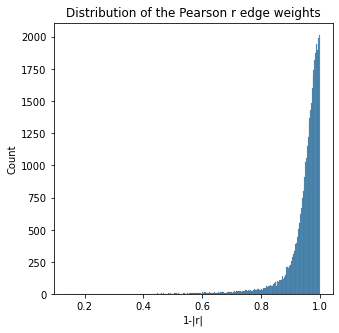

<IPython.core.display.Javascript object>

In [182]:
plt.figure(figsize=[5, 5])
sns.histplot(pearsonr_weights)
plt.title("Distribution of the Pearson r edge weights")
plt.xlabel("1-|r|")
plt.show()

In [192]:
# pearsonp_weights = np.array(
#     list(nx.get_edge_attributes(selected_ppi, "pearsonp").values())
# )

<IPython.core.display.Javascript object>

In [193]:
# plt.figure(figsize=[5, 5])
# sns.histplot(pearsonp_weights)
# plt.title("Distribution of the Pearson bootstrap p edge weights")
# plt.xlabel("p")
# plt.show()

<IPython.core.display.Javascript object>

### 4.2. Spearman correlation-based edge weights

In [194]:
spearmanr_weights = np.array(
    list(nx.get_edge_attributes(selected_ppi, "spearmanr").values())
)

<IPython.core.display.Javascript object>

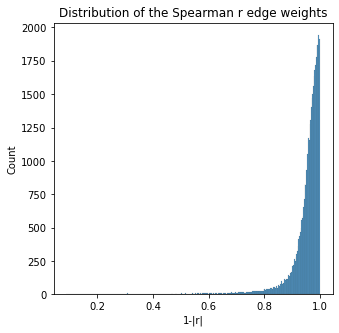

<IPython.core.display.Javascript object>

In [195]:
plt.figure(figsize=[5, 5])
sns.histplot(spearmanr_weights)
plt.title("Distribution of the Spearman r edge weights")
plt.xlabel("1-|r|")
plt.show()

In [196]:
# spearmanp_weights = np.array(
#     list(nx.get_edge_attributes(selected_ppi, "spearmanp").values())
# )

<IPython.core.display.Javascript object>

In [197]:
# plt.figure(figsize=[5, 5])
# sns.histplot(spearmanp_weights)
# plt.title("Distribution of the Spearman bootstrap p edge weights")
# plt.xlabel("bootstrap p")
# plt.show()

<IPython.core.display.Javascript object>

### 4.3. Mutual information-based edge weights

In [198]:
mi_weights = np.array(list(nx.get_edge_attributes(selected_ppi, "mi").values()))

<IPython.core.display.Javascript object>

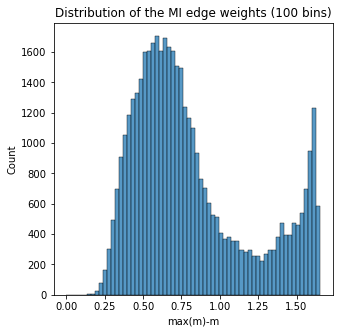

<IPython.core.display.Javascript object>

In [199]:
plt.figure(figsize=[5, 5])
sns.histplot(np.max(mi_weights) - (mi_weights))
plt.title("Distribution of the MI edge weights (100 bins)")
plt.xlabel("max(m)-m")
plt.show()

----

## 5. PCST preprocessing

After having computed the respective metrics we will now construct different version of the PPI with associated edge weights and node prizes for the inference of the PCST algorithm.

### 5a. Version 1

In the first version, we will use the human PPI that was pruned to remove low-confidence edges and includes only nodes corresponding to genes covered by the scRNAseq data set.

We will define the node prizes as given by the absolute log-fold change when comparing the U20S cells with other cells from the CCLE cancer dataset. Missing values are replaced by zeros.

The chosen edge weights are given by $1-|r_{spearman}|$.

In [200]:
ppi_version_1 = selected_ppi.copy()

abs_log_fc = marker_results.loc[:, "abs_log_fc"]

## Set node prizes
prize_dict = dict()
for node in ppi_version_1.nodes(data=True):
    try:
        node[-1]["prize"] = abs_log_fc[node[0]]
    except KeyError:
        node[-1]["prize"] = 0


## Set edge weights
for edge in ppi_version_1.edges(data=True):
    edge[-1]["cost"] = edge[-1]["spearmanr"]

## Save network
nx.write_gpickle(
    ppi_version_1,
    "../../../data/ppi/ppi_confidence_0542_hub_230_pruned_ccle_abslogfc_spearmanr.pkl",
)

<IPython.core.display.Javascript object>

---

### 5b. Version 2

Alternatively, we will construct a second version that uses the same node prizes as before and the same underlying skeleton but rather uses the p-value for a non-zero Spearman correlation as edge weights.

In [201]:
# ppi_version_2 = selected_ppi.copy()

# abs_log_fc = marker_results.loc[:, "abs_log_fc"]

# ## Set node prizes
# prize_dict = dict()
# for node in ppi_version_2.nodes(data=True):
#     try:
#         node[-1]["prize"] = abs_log_fc[node[0]]
#     except KeyError:
#         node[-1]["prize"] = 0


# ## Set edge weights
# for edge in ppi_version_2.edges(data=True):
#     edge[-1]["cost"] = edge[-1]["spearmanp"]

# ## Save network
# nx.write_gpickle(
#     ppi_version_2,
#     "../../../data/ppi/ppi_confidence_0542_hub_230_pruned_ccle_abslogfc_spearmanp.pkl",
# )

<IPython.core.display.Javascript object>

---

### 5c. Version 3/4

To enforce the PCST to span the ORF targets we follow the strategy proposed by and set the prizes of the ORF targets to 10 that is larger than the maximum prize of any other node.

In [202]:
ppi_version_3 = selected_ppi.copy()

abs_log_fc = marker_results.loc[:, "abs_log_fc"]

## Set node prizes
for node in ppi_version_3.nodes(data=True):
    if node[0] in orf_targets:
        node[-1]["prize"] = np.max(abs_log_fc)
    else:
        try:
            node[-1]["prize"] = abs_log_fc[node[0]]
        except KeyError:
            node[-1]["prize"] = 0


## Set edge weights
for edge in ppi_version_3.edges(data=True):
    edge[-1]["cost"] = edge[-1]["spearmanr"]

## Save network
nx.write_gpickle(
    ppi_version_3,
    "../../../data/ppi/ppi_confidence_0542_hub_230_pruned_ccle_abslogfc_orf_maxp_spearmanr.pkl",
)

<IPython.core.display.Javascript object>

In [203]:
# ppi_version_4 = selected_ppi.copy()

# abs_log_fc = marker_results.loc[:, "abs_log_fc"]

# ## Set node prizes
# for node in ppi_version_4.nodes(data=True):
#     if node[0] in orf_targets:
#         node[-1]["prize"] = np.max(abs_log_fc)
#     else:
#         try:
#             node[-1]["prize"] = abs_log_fc[node[0]]
#         except KeyError:
#             node[-1]["prize"] = 0


# ## Set edge weights
# for edge in ppi_version_4.edges(data=True):
#     edge[-1]["cost"] = edge[-1]["spearmanp"]

# ## Save network
# nx.write_gpickle(
#     ppi_version_4,
#     "../../../data/ppi/ppi_confidence_0542_hub_230_pruned_ccle_abslogfc_orf_maxp_spearmanp.pkl",
# )

<IPython.core.display.Javascript object>

---

## 6. Analyses of the PCST preprocessed graphs

To get a better understanding of the input graphs that we constructed for the PCST driven inference we will plot some basic characteristics of the input graph. For that we will first focus on the 3rd version that we constructed for which the edge weights are given by $1-|r_{Spearman}|$ and the prizes by the absolute log fold-change with the ones of the ORF targets constantly set to the maximum log fold-change.

In [204]:
graph = ppi_version_3
prizes = dict(nx.get_node_attributes(graph, "prize"))
costs = dict(nx.get_edge_attributes(graph, "cost"))

<IPython.core.display.Javascript object>

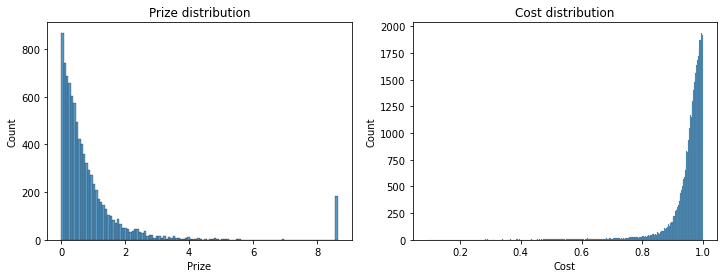

<IPython.core.display.Javascript object>

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.histplot(prizes.values(), ax=ax[0], legend=False)
ax[0].set_title("Prize distribution")
ax[0].set_xlabel("Prize")
ax[1] = sns.histplot(costs.values(), ax=ax[1], legend=False)
ax[1].set_title("Cost distribution")
ax[1].set_xlabel("Cost")
plt.show()
plt.show()

We are now interested if there is a relationship between the prizes and edge costs and the corresponding nodes i.e. those that the edges associated with the costs connect to. To this end, we will plot the prizes by the corresponding edge degree and as well as the edge costs.

In [228]:
degrees = dict(graph.degree())
degrees = {k: v for k, v in sorted(degrees.items())}
prizes = {k: v for k, v in sorted(prizes.items())}
orf_target_colors = []
for k in prizes:
    orf_target_colors.append(k in orf_targets)

<IPython.core.display.Javascript object>

In [227]:
mean_node_cost = []
std_node_cost = []
node_degrees = []
node_orf_target_colors = []
for node in graph.nodes():
    node_orf_target_colors.append(node in orf_targets)
    node_degrees.append(graph.degree(node))
    edges = graph.edges(node, data=True)
    node_cost = []
    for edge in edges:
        node_cost.append(edge[-1]["cost"])
    mean_node_cost.append(np.mean(node_cost))
    std_node_cost.append(np.std(node_cost))

<IPython.core.display.Javascript object>

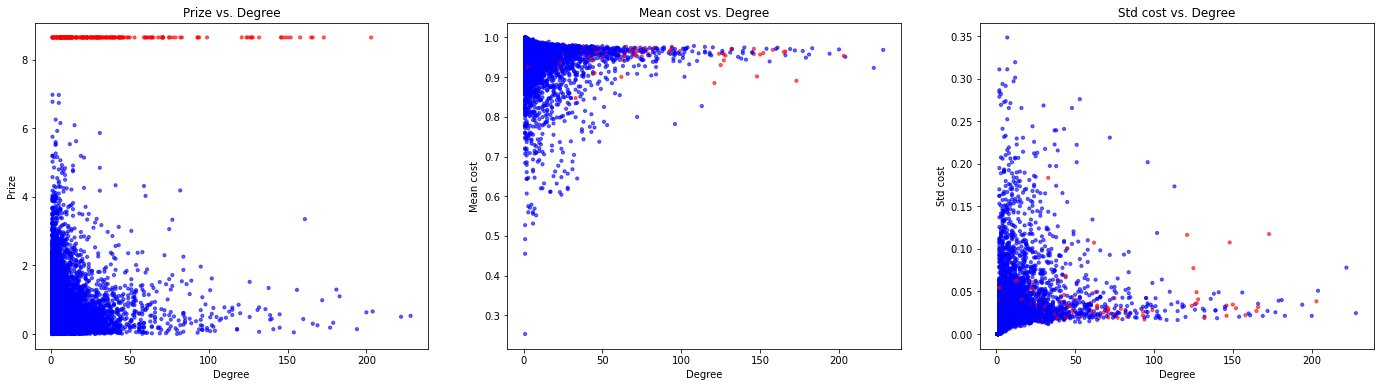

<IPython.core.display.Javascript object>

In [253]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[24, 6])
ax = ax.flatten()
ax[0].scatter(
    degrees.values(),
    prizes.values(),
    c=orf_target_colors,
    s=10,
    cmap="bwr",
    alpha=0.6,
)
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Prize")
ax[0].set_title("Prize vs. Degree")

ax[1].scatter(
    node_degrees, mean_node_cost, c=node_orf_target_colors, s=10, cmap="bwr", alpha=0.6
)
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Mean cost")
ax[1].set_title("Mean cost vs. Degree")

ax[2].scatter(
    node_degrees, std_node_cost, c=node_orf_target_colors, s=10, cmap="bwr", alpha=0.6
)
ax[2].set_xlabel("Degree")
ax[2].set_ylabel("Std cost")
ax[2].set_title("Std cost vs. Degree")
plt.show()

The above plots illustrate that the most of nodes with a very high degree get relatively low yet non-zero prizes. Note, that due to the manual inflation of the prizes for the ORF targets that does not apply to those (marked in red). Additionally, most nodes with high-degrees are connected to many high cost edges as shown by the mean cost. Recalling the histogram of the overall edge cost distribution this is not surprising. The variance of the edge cost also decreases with increasing degree on average.

Jointly, this suggest that we might want to exclude even more high-degree nodes. However, this will also likely cause the largest connected component of the induced subgraph to span less of the ORF targets. Thus, it would be important to either manually include these as long as they can be connected to the largest connected component or that the ORF targets that are filtered out are of no special interest for the downstream analyses.

In [274]:
targets = ["CASP8", "CASP9", "BCL2L11", "DDIT3", "GRB10"]
dist = np.zeros([5, 5])
collect = np.zeros([5, 5])
for i in range(5):
    for j in range(5):
        dist[i, j] = nx.shortest_path_length(
            graph, source=targets[i], target=targets[j], weight="cost"
        )
        sp = nx.shortest_path(
            graph, source=targets[i], target=targets[j], weight="cost"
        )
        collect[i, j] = np.sum([prizes[n] for n in sp]) - dist[i, j]
dist = pd.DataFrame(dist, index=targets, columns=targets)
collect = pd.DataFrame(collect, index=targets, columns=targets)

<IPython.core.display.Javascript object>

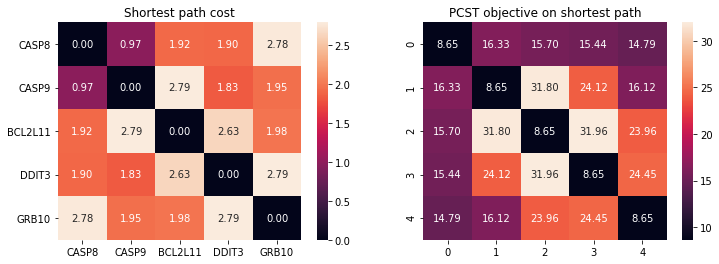

<IPython.core.display.Javascript object>

In [284]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.heatmap(dist, annot=True, ax=ax[0], fmt=".2f")
ax[0].set_title("Shortest path cost")
ax[1] = sns.heatmap(collect, annot=True, ax=ax[1], fmt=".2f")
ax[1].set_title("PCST objective on shortest path")
plt.show()